In [131]:
import numpy as np
import pandas as pd
import gc
import datetime

from sklearn.model_selection import KFold
import lightgbm as lgb

import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

from scipy.spatial.distance import cosine

NFOLD = 5
DATA_PATH = './'

In [102]:
train = pd.read_csv(DATA_PATH + "train.csv")
test = pd.read_csv(DATA_PATH + "test.csv")
print(f'train -- {train.shape}')

train.drop(['per_square_meter_price'], axis=1, inplace=True)

train['target'] = 1
train[train['price_type'] == 0]['target'] = 1
train[train['price_type'] == 1]['target'] = 0
test['target'] = 0

print(f'train -- {train.shape}')
print(f'test -- {test.shape}')

n_train = train.shape[0]
df = pd.concat([train, test], axis = 0)
df.drop(['date'], axis=1, inplace=True)
df.drop(['lng'], axis=1, inplace=True)
df.drop(['lat'], axis=1, inplace=True)
df.drop(['region'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


train -- (279792, 77)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


train -- (279792, 77)
test -- (2974, 77)


In [103]:
print(df.shape)

(282766, 73)


In [104]:
del train, test
gc.collect()

451

In [105]:
predictors = list(df.columns.difference(['id', 'target', 'price_type']))
df_train = df.iloc[:n_train].copy()
cols_to_remove = [c for c in predictors if df_train[c].nunique() == 1]
df.drop(cols_to_remove, axis=1, inplace=True)

In [106]:
# Shuffle dataset
df = df.iloc[np.random.permutation(len(df))]
df.reset_index(drop=True, inplace=True)

# Drop price type
price_type_column = df['price_type']
df.drop(['price_type'], axis=1, inplace=True)

# Get target column name
target = 'target'

# lgb params
lgb_params = {
        'boosting': 'gbdt',
        'application': 'binary',
        'metric': 'auc', 
        'learning_rate': 0.001 ,
        'num_leaves': 70,
        'max_depth': 8,
        'min_data_in_leaf': 21,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'feature_fraction': 0.9,
        'is_unbalance': True, 
} 

# Get folds for k-fold CV
folds = KFold(n_splits = NFOLD, shuffle = True, random_state = 0)
fold = folds.split(df)
    
eval_score = 0
n_estimators = 0
eval_preds = np.zeros(df.shape[0])

In [107]:
data_numeric = df.select_dtypes(exclude=['object'])
data_obj = df.select_dtypes(include=['object']).copy()

In [108]:
for c in data_obj:
    data_obj[c] = pd.factorize(data_obj[c])[0]

In [109]:
df = pd.concat([data_numeric, data_obj], axis=1)
y = df['target'];

In [110]:
for i, (train_index, test_index) in enumerate(fold):
    print( "\n[{}] Fold {} of {}".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), i+1, NFOLD))
    train_X, valid_X = df[predictors].values[train_index], df[predictors].values[test_index]
    train_y, valid_y = df[target].values[train_index], df[target].values[test_index]

    dtrain = lgb.Dataset(train_X, label = train_y,
                          feature_name = list(predictors)
                          )
    
    dvalid = lgb.Dataset(valid_X, label = valid_y,
                          feature_name = list(predictors)
                          )
        
    eval_results = {}
    
    bst = lgb.train(lgb_params, 
                         dtrain, 
                         valid_sets = [dtrain, dvalid], 
                         valid_names = ['train', 'valid'], 
                         evals_result = eval_results, 
                         num_boost_round = 500,
                         early_stopping_rounds = 100,
                         verbose_eval = 100)
    
    print("\nRounds:", bst.best_iteration)
    print("AUC: ", eval_results['valid']['auc'][bst.best_iteration-1])

    n_estimators += bst.best_iteration
    eval_score += eval_results['valid']['auc'][bst.best_iteration-1]
   
    eval_preds[test_index] += bst.predict(valid_X, num_iteration = bst.best_iteration)
    
n_estimators = int(round(n_estimators/NFOLD,0))
eval_score = round(eval_score/NFOLD,6)

print("\nModel Report")
print("Rounds: ", n_estimators)
print("AUC: ", eval_score)    


[2021-09-25 21:01:59] Fold 1 of 5
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.978258	valid's auc: 0.963682
[200]	train's auc: 0.979846	valid's auc: 0.964824
[300]	train's auc: 0.981213	valid's auc: 0.966547
[400]	train's auc: 0.982104	valid's auc: 0.967562
[500]	train's auc: 0.983068	valid's auc: 0.968776
Did not meet early stopping. Best iteration is:
[500]	train's auc: 0.983068	valid's auc: 0.968776

Rounds: 500
AUC:  0.9687756289786946

[2021-09-25 21:03:08] Fold 2 of 5
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.97938	valid's auc: 0.971197
[200]	train's auc: 0.980461	valid's auc: 0.971331
[300]	train's auc: 0.982031	valid's auc: 0.972412
[400]	train's auc: 0.983055	valid's auc: 0.973023
[500]	train's auc: 0.983748	valid's auc: 0.973388
Did not meet early stopping. Best iteration is:
[499]	train's auc: 0.983749	valid's auc: 0.97339

Rounds: 499
AUC:  0.9733901693584953

[2021-09-25 21:04:19] Fold 3 of 5

<Figure size 1080x576 with 0 Axes>

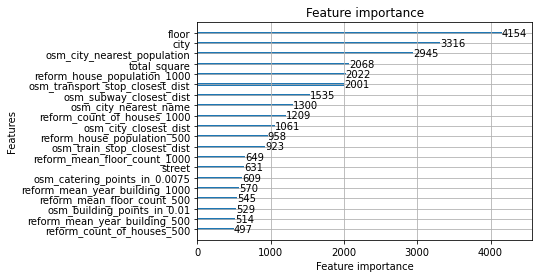

In [114]:
plt.figure(figsize=(15, 8))
lgb.plot_importance(bst, max_num_features=20)

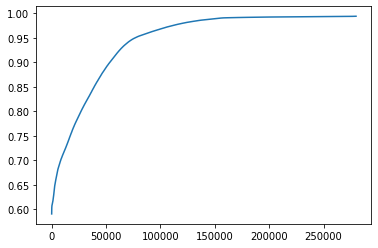

In [115]:
df_av = df[['id', 'target']].copy()
df_av['preds'] = eval_preds
df_av_train = df_av[df_av.target == 1]
df_av_train = df_av_train.sort_values(by=['preds']).reset_index(drop=True)

# Check distribution
df_av_train.preds.plot()

# Store to feather
df_av_train[['id', 'preds']].reset_index(drop=True).to_feather('adversarial_validation.ft')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


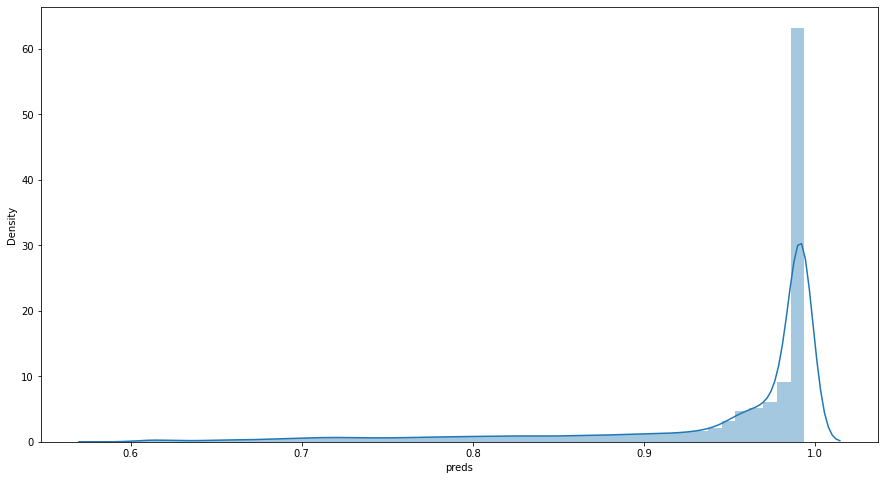

In [116]:
plt.figure(figsize=(15, 8))
sns.distplot(df_av_train['preds'])

In [117]:
for th in [0.6, 0.7, 0.8]:
    print(f"Количество объектов трейна, которые модель слабо отличает от теста при пороге == {th}: {df_av_train[df_av_train['preds'] < th].shape[0]}")

Количество объектов трейна, которые модель слабо отличает от теста при пороге == 0.6: 36
Количество объектов трейна, которые модель слабо отличает от теста при пороге == 0.7: 8310
Количество объектов трейна, которые модель слабо отличает от теста при пороге == 0.8: 26981


In [119]:
CONFIDENCE_RATE = 0.8

similar_id = df_av_train[df_av_train['preds'] < CONFIDENCE_RATE]['id']
similar_id.to_pickle('similar.pkl')

df['price_type'] = price_type_column 
df.to_pickle('df.pkl')

In [120]:
df.shape

(282766, 73)

In [121]:
df['price_type']

0         0
1         0
2         0
3         0
4         0
         ..
282761    0
282762    0
282763    0
282764    0
282765    0
Name: price_type, Length: 282766, dtype: int64

In [122]:
def prepare(df):
    df = df.drop(['city', 'osm_city_nearest_name', 'date'], axis=1)
    df = df.fillna(0.0)
    df.drop(['id'], axis=1, inplace=True)
    df = df[pd.to_numeric(df['floor'], errors='coerce').notnull()]
    df['floor'] = pd.to_numeric(df['floor'], errors='coerce')
    # regions = df['region'].unique()
    # reg_dict = dict(zip(regions, range(len(regions))))
    # df['region'] = [reg_dict[r] for r in df['region']]
    # df['street'] = [s if type(s) == float else float(s[1:]) for s in df['street']]
    
    return df.astype(float)

In [128]:
similar = df[df['id'].isin(similar_id)]

In [129]:
similar.shape

(26981, 73)

In [130]:
ones_from_train = df[df['price_type'] == 1]
ones_from_train.shape

(7467, 73)

In [140]:
similarities = dict.fromkeys(similar['id'])

In [149]:
similarities[similar.loc[4, :]['id']]

In [146]:
for v_1 in similar.index:
    print(v_1)
    break

4


In [152]:
from tqdm import tqdm

In [ ]:
for i_1 in tqdm(similar.index):
    best_sim = 0

    for i_2 in ones_from_train.index:
        cur_sim = cosine(similar.loc[i_1, :], ones_from_train.loc[i_2, :])
        if cur_sim:
            best_sim = cur_sim
            best_vector = ones_from_train.loc[i_2, :]
        
    
    similarities[similar.loc[i_1, :]['id']] = (best_vector, best_sim)

  1%|          | 181/26981 [16:42<41:07:50,  5.53s/it]